# Indexing


Importing necessary libraries

In [1]:
import bs4
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

USER_AGENT environment variable not set, consider setting it to identify your requests.


Setting environment variabless

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_PROJECT"] = "RAG_Variant_Interpretation_Assistant"

## Loading domain-specific documents from Knowledge Base

Loading webpages


In [ ]:
from knowledge_base.websites import websites

loader = WebBaseLoader(
    web_paths=(websites),
)

docs = loader.load()

Loading PDF research papers

In [ ]:
from pathlib import Path
from langchain_community.document_loaders import PyPDFLoader
from langchain.schema import Document

for pdf_file in Path("knowledge_base/").rglob("*.pdf"):
    loader = PyPDFLoader(str(pdf_file))
    pages = loader.load()
    combined_text = "\n".join(p.page_content for p in pages)

    docs.append(
        Document(
            page_content=combined_text, metadata={"source": pdf_file.name}
        )
    )

Chunking all documents in the Knowledge Base

In [ ]:
for doc in docs:
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000, chunk_overlap=200
    )
    splits = text_splitter.split_documents([doc])
    vectorstore = Chroma.from_documents(
        collection_name="variant_annotation_kb",
        documents=splits,
        embedding=OpenAIEmbeddings(),
        persist_directory="./chroma_langchain_db",
    )
    retriever = vectorstore.as_retriever()

Preparing RAG chain using deafault prompt:\
`You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:`

In [ ]:
prompt = hub.pull("rlm/rag-prompt")

llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

Negative test of retrieval

In [ ]:
rag_chain.invoke("What is the receipt for pancakes?")

"I don't know."

Testsing semantic search robustness

In [ ]:
rag_chain.invoke(
    "Who is the the author of 'Variant interpretation using population databases: Lessons from gnomAD'?"
)

"The author of 'Variant interpretation using population databases: Lessons from gnomAD' is Sanna Gudmundsson, Moriel Singer‐Berk, Nicholas A. Watts, William Phu, Julia K. Goodrich, Matthew Solomonson, Genome Aggregation Database Consortium, Heidi L. Rehm, Daniel G. MacArthur, and Anne O’Donnell‐Luria."

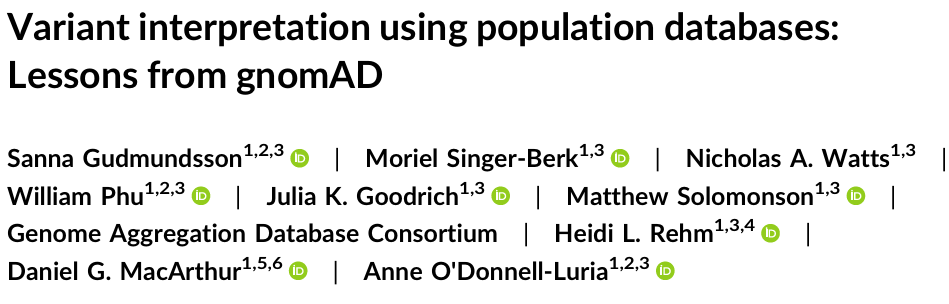

Tests succseedss